1. **Importations & Configuration**

In [76]:
# Analyse des Données de Qualité de l'Air en Temps Réel
# Notebook pour collecter, analyser et visualiser les données d'APIs

import requests
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import datetime
from typing import Dict, Optional, List
from tabulate import tabulate

import warnings
warnings.filterwarnings('ignore')

# Configuration des graphiques
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)

# Configuration des APIs
AQICN_API_KEY = "d6dc128a0628a9274ab78ee69152ca8d572dc7cc"
OPENWEATHER_API_KEY = "dd2d8c2c92a3ebe773b453884a7f08c0"

# Villes françaises avec coordonnées
FRENCH_CITIES = [
    ("Paris", 48.8566, 2.3522),
    ("Marseille", 43.2965, 5.3698),
    ("Lyon", 45.7640, 4.8357),
    ("Toulouse", 43.6045, 1.4440),
    ("Nice", 43.7102, 7.2620),
    ("Nantes", 47.2184, -1.5536),
    ("Montpellier", 43.6109, 3.8772),
    ("Strasbourg", 48.5734, 7.7521),
    ("Bordeaux", 44.8378, -0.5792),
    ("Lille", 50.6292, 3.0573),
    ("Rennes", 48.1173, -1.6778),
    ("Reims", 49.2583, 4.0317),
    ("Saint-Étienne", 45.4397, 4.3872),
    ("Le Havre", 49.4944, 0.1079),
    ("Toulon", 43.1242, 5.9280),
    ("Grenoble", 45.1885, 5.7245),
    ("Dijon", 47.3220, 5.0415),
    ("Angers", 47.4784, -0.5632),
    ("Nîmes", 43.8367, 4.3601),
    ("Villeurbanne", 45.7719, 4.8902)
]

2. **Collecte des Données AQICN**

In [3]:
class AQICNCollector:
    BASE_URL = "https://api.waqi.info/feed/{city}/?token={key}"
    
    def __init__(self, api_key: str):
        self.api_key = api_key
        
    def fetch_full_data(self, city: str) -> Optional[Dict]:
        url = self.BASE_URL.format(city=city, key=self.api_key)
        try:
            response = requests.get(url, timeout=30)
            response.raise_for_status()
            data = response.json()
            
            if data['status'] != 'ok':
                print(f"❌ Erreur API pour {city}: {data.get('message', 'Status not OK')}")
                return None
                
            return self._transform_data(data['data'], city)
            
        except Exception as e:
            print(f"❌ Erreur réseau pour {city}: {str(e)}")
            return None
            
    def _transform_data(self, raw_data: Dict, city: str) -> Dict:
        """Extraction complète de tous les champs disponibles"""
        iaqi = raw_data.get('iaqi', {})
        time_data = raw_data.get('time', {})
        
        return {
            'source': 'aqicn',
            'city': city,
            'timestamp': datetime.now().isoformat(),
            'data_timestamp': f"{time_data.get('s')}T{time_data.get('tz')}",
            'aqi': raw_data.get('aqi'),
            'dominant_pollutant': raw_data.get('dominentpol'),
            'station': {
                'name': raw_data.get('city', {}).get('name'),
                'url': raw_data.get('city', {}).get('url'),
                'geo': raw_data.get('city', {}).get('geo')
            },
            'pollutants': {
                p: v.get('v') for p, v in iaqi.items() if isinstance(v, dict)
            },
            'attributions': raw_data.get('attributions', []),
            'forecast': raw_data.get('forecast', {})
        }

2. **Collecte des Données OpenWeatherCollector**

In [7]:
class OpenWeatherCollector:
    AIR_POLLUTION_URL = "http://api.openweathermap.org/data/2.5/air_pollution?lat={lat}&lon={lon}&appid={key}"
    WEATHER_URL = "https://api.openweathermap.org/data/2.5/weather?lat={lat}&lon={lon}&appid={key}&units=metric&lang=fr"
    
    def __init__(self, api_key: str):
        self.api_key = api_key
        
    def fetch_full_data(self, city: str, lat: float, lon: float) -> Optional[Dict]:
        try:
            # Données pollution
            pollution = self._fetch_air_pollution(lat, lon)
            # Données météo standard
            weather = self._fetch_weather(lat, lon)
            
            return {
                'source': 'openweather',
                'city': city,
                'timestamp': datetime.now().isoformat(),
                'coordinates': {'lat': lat, 'lon': lon},
                'air_pollution': pollution,
                'weather': weather
            }
            
        except Exception as e:
            print(f"❌ Erreur OpenWeather pour {city}: {str(e)}")
            return None
            
    def _fetch_air_pollution(self, lat: float, lon: float) -> Dict:
        url = self.AIR_POLLUTION_URL.format(lat=lat, lon=lon, key=self.api_key)
        response = requests.get(url, timeout=30)
        response.raise_for_status()
        return response.json()
        
    def _fetch_weather(self, lat: float, lon: float) -> Dict:
        url = self.WEATHER_URL.format(lat=lat, lon=lon, key=self.api_key)
        response = requests.get(url, timeout=30)
        response.raise_for_status()
        return response.json()


3. **Collecte des données en temps réel**

In [10]:
def collect_all_data():
    """Collecte toutes les données des APIs"""
    print("🔄 Collecte des données en temps réel...")
    
    # Initialisation des collecteurs
    aqicn_collector = AQICNCollector(AQICN_API_KEY)
    openweather_collector = OpenWeatherCollector(OPENWEATHER_API_KEY)
    
    aqicn_data = []
    openweather_data = []
    
    for city, lat, lon in FRENCH_CITIES:
        print(f"📍 Collecte pour {city}...")
        
        # Données AQICN
        aqicn_result = aqicn_collector.fetch_full_data(city)
        if aqicn_result:
            aqicn_data.append(aqicn_result)
            print(f"  AQICN: AQI={aqicn_result.get('aqi', 'N/A')}")
        
        # Données OpenWeather
        weather_result = openweather_collector.fetch_full_data(city, lat, lon)
        if weather_result:
            openweather_data.append(weather_result)
            temp = weather_result.get('weather', {}).get('main', {}).get('temp', 'N/A')
            print(f"  OpenWeather: Temp={temp}°C")
        
        # Pause pour respecter les limites d'API
        import time
        time.sleep(1)
    
    return aqicn_data, openweather_data

# Collecte des données
aqicn_raw_data, openweather_raw_data = collect_all_data()

print(f"\n📊 Données collectées:")
print(f"  • AQICN: {len(aqicn_raw_data)} villes")
print(f"  • OpenWeather: {len(openweather_raw_data)} villes")


🔄 Collecte des données en temps réel...
📍 Collecte pour Paris...
  AQICN: AQI=62
  OpenWeather: Temp=22.19°C
📍 Collecte pour Marseille...
  AQICN: AQI=58
  OpenWeather: Temp=26.3°C
📍 Collecte pour Lyon...
  AQICN: AQI=7
  OpenWeather: Temp=22.15°C
📍 Collecte pour Toulouse...
  AQICN: AQI=34
  OpenWeather: Temp=24.97°C
📍 Collecte pour Nice...
  AQICN: AQI=83
  OpenWeather: Temp=27.38°C
📍 Collecte pour Nantes...
  AQICN: AQI=32
  OpenWeather: Temp=22.06°C
📍 Collecte pour Montpellier...
  AQICN: AQI=35
  OpenWeather: Temp=26.94°C
📍 Collecte pour Strasbourg...
  AQICN: AQI=20
  OpenWeather: Temp=23.05°C
📍 Collecte pour Bordeaux...
  AQICN: AQI=22
  OpenWeather: Temp=24.21°C
📍 Collecte pour Lille...
  AQICN: AQI=61
  OpenWeather: Temp=23.13°C
📍 Collecte pour Rennes...
  AQICN: AQI=29
  OpenWeather: Temp=21.78°C
📍 Collecte pour Reims...
  AQICN: AQI=38
  OpenWeather: Temp=22°C
📍 Collecte pour Saint-Étienne...
  AQICN: AQI=10
  OpenWeather: Temp=18.17°C
📍 Collecte pour Le Havre...
  AQICN: AQ

4. **Transformation en DataFrames**

In [12]:
def transform_aqicn_data(raw_data: List[Dict]) -> pd.DataFrame:
    """Transforme les données AQICN en DataFrame"""
    records = []
    
    for data in raw_data:
        record = {
            'city': data['city'],
            'timestamp': data['timestamp'],
            'aqi': data.get('aqi'),
            'dominant_pollutant': data.get('dominant_pollutant'),
            'station_name': data.get('station', {}).get('name'),
            'station_geo': str(data.get('station', {}).get('geo', [])),
        }
        
        # Ajout des polluants
        pollutants = data.get('pollutants', {})
        for pollutant, value in pollutants.items():
            record[f'pollutant_{pollutant}'] = value
            
        records.append(record)
    
    return pd.DataFrame(records)

def transform_openweather_data(raw_data: List[Dict]) -> pd.DataFrame:
    """Transforme les données OpenWeather en DataFrame"""
    records = []
    
    for data in raw_data:
        weather = data.get('weather', {})
        pollution = data.get('air_pollution', {})
        
        record = {
            'city': data['city'],
            'timestamp': data['timestamp'],
            'latitude': data['coordinates']['lat'],
            'longitude': data['coordinates']['lon'],
        }
        
        # Données météo
        if 'main' in weather:
            main = weather['main']
            record.update({
                'temperature': main.get('temp'),
                'feels_like': main.get('feels_like'),
                'humidity': main.get('humidity'),
                'pressure': main.get('pressure'),
            })
        
        if 'wind' in weather:
            record['wind_speed'] = weather['wind'].get('speed')
            record['wind_deg'] = weather['wind'].get('deg')
        
        if 'weather' in weather and weather['weather']:
            record['weather_main'] = weather['weather'][0].get('main')
            record['weather_description'] = weather['weather'][0].get('description')
        
        # Données de pollution
        if 'list' in pollution and pollution['list']:
            aqi_data = pollution['list'][0]
            record['aqi_openweather'] = aqi_data.get('main', {}).get('aqi')
            
            components = aqi_data.get('components', {})
            for component, value in components.items():
                record[f'component_{component}'] = value
        
        records.append(record)
    
    return pd.DataFrame(records)

# Transformation des données
aqicn_df = transform_aqicn_data(aqicn_raw_data)
openweather_df = transform_openweather_data(openweather_raw_data)

print(f"\n📋 DataFrames créés:")
print(f"  • AQICN: {aqicn_df.shape[0]} lignes, {aqicn_df.shape[1]} colonnes")
print(f"  • OpenWeather: {openweather_df.shape[0]} lignes, {openweather_df.shape[1]} colonnes")


📋 DataFrames créés:
  • AQICN: 20 lignes, 18 colonnes
  • OpenWeather: 20 lignes, 21 colonnes


5. **Aperçu des données**

In [82]:
print("\n" + "="*50)
print("📊 APERÇU DES DONNÉES AQICN")
print("="*50)
if not aqicn_df.empty:
    print(aqicn_df.head())
    print(f"\nColonnes: {list(aqicn_df.columns)}")
    
    # Statistiques AQI
    if 'aqi' in aqicn_df.columns:
        print(f"\n📈 Statistiques AQI:")
        print(aqicn_df['aqi'].describe())

print("\n" + "="*50)
print("🌤️ APERÇU DES DONNÉES OPENWEATHER")
print("="*50)
if not openweather_df.empty:
    print(openweather_df.head())
    print(f"\nColonnes: {list(openweather_df.columns)}")
    
    # Statistiques météo
    numeric_cols = openweather_df.select_dtypes(include=[np.number]).columns
    if len(numeric_cols) > 0:
        print(f"\n📈 Statistiques numériques:")
        print(openweather_df[numeric_cols].describe())



📊 APERÇU DES DONNÉES AQICN
        city                   timestamp  aqi dominant_pollutant  \
0      Paris  2025-06-16T13:36:26.454218   62               pm25   
1  Marseille  2025-06-16T13:36:29.047975   58               pm10   
2       Lyon  2025-06-16T13:36:31.712410    7               pm10   
3   Toulouse  2025-06-16T13:36:34.174997   34                 o3   
4       Nice  2025-06-16T13:36:36.670373   83               pm25   

                        station_name                station_geo  pollutant_co  \
0                              Paris     [48.856614, 2.3522219]           0.1   
1  Marseille 5 Avenues, PACA, France      [43.305287, 5.394716]           0.1   
2         Lyon Trafic Jaurès, France  [45.74972628, 4.84439392]           NaN   
3         Toulouse Berthelot, France  [43.5873309, 1.444026232]           NaN   
4           Nice Arson, PACA, France      [43.702075, 7.286256]           NaN   

   pollutant_h  pollutant_no2  pollutant_o3  pollutant_p  pollutant_pm10  \


6. **Analyse de la qualité des données**

In [64]:
class DataQualityAnalyzer:
    @staticmethod
    def analyze_completeness(df, source_name):
        """Analyse du taux de complétude"""
        print(f"\n🔍 Analyse de complétude - {source_name}")
        print("-" * 40)
        
        total_cells = df.size
        missing_cells = df.isnull().sum().sum()
        completeness = (1 - missing_cells / total_cells) * 100
        
        print(f"Taux de complétude global: {completeness:.2f}%")
        
        # Par colonne
        missing_by_col = df.isnull().sum()
        missing_pct = (missing_by_col / len(df)) * 100
        
        missing_summary = pd.DataFrame({
            'Valeurs manquantes': missing_by_col,
            'Pourcentage': missing_pct
        }).sort_values('Pourcentage', ascending=False)
        
        if missing_summary['Valeurs manquantes'].sum() > 0:
            print("\nValeurs manquantes par colonne:")
            print(missing_summary[missing_summary['Valeurs manquantes'] > 0])
        else:
            print("✅ Aucune valeur manquante détectée")
        
        return missing_summary
    
    @staticmethod
    def analyze_data_ranges(df, source_name):
        """Analyse des plages de valeurs"""
        print(f"\n📊 Analyse des plages - {source_name}")
        print("-" * 40)
        
        numeric_cols = df.select_dtypes(include=[np.number]).columns
        
        for col in numeric_cols:
            values = df[col].dropna()
            if len(values) > 0:
                print(f"{col}: {values.min():.2f} → {values.max():.2f} (moy: {values.mean():.2f})")

# Analyse de qualité
analyzer = DataQualityAnalyzer()

if not aqicn_df.empty:
    analyzer.analyze_completeness(aqicn_df, "AQICN")
    analyzer.analyze_data_ranges(aqicn_df, "AQICN")

if not openweather_df.empty:
    analyzer.analyze_completeness(openweather_df, "OpenWeather")
    analyzer.analyze_data_ranges(openweather_df, "OpenWeather")



🔍 Analyse de complétude - AQICN
----------------------------------------
Taux de complétude global: 84.17%

Valeurs manquantes par colonne:
                Valeurs manquantes  Pourcentage
pollutant_co                    17         85.0
pollutant_so2                   14         70.0
pollutant_wg                     8         40.0
pollutant_dew                    7         35.0
pollutant_pm25                   5         25.0
pollutant_o3                     4         20.0
pollutant_no2                    1          5.0
pollutant_pm10                   1          5.0

📊 Analyse des plages - AQICN
----------------------------------------
aqi: 7.00 → 83.00 (moy: 34.00)
pollutant_co: 0.10 → 0.10 (moy: 0.10)
pollutant_h: 31.00 → 92.00 (moy: 60.44)
pollutant_no2: 1.10 → 20.60 (moy: 8.40)
pollutant_o3: 11.00 → 35.30 (moy: 26.59)
pollutant_p: 1010.80 → 1045.20 (moy: 1024.72)
pollutant_pm10: 7.00 → 63.00 (moy: 22.26)
pollutant_pm25: 23.00 → 83.00 (moy: 48.00)
pollutant_so2: 0.50 → 1.20 (moy: 0.

7. **Visualisations**

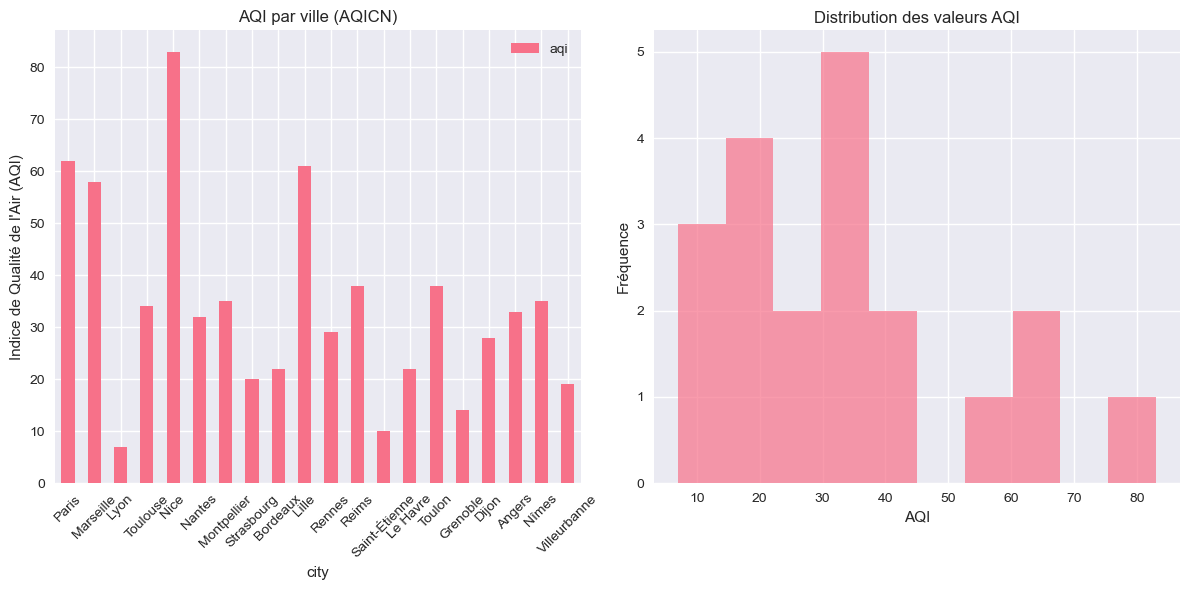

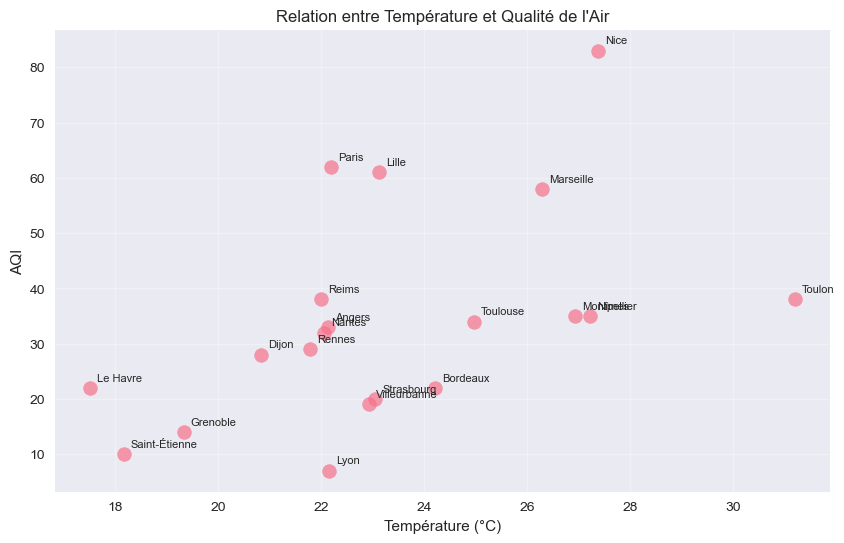

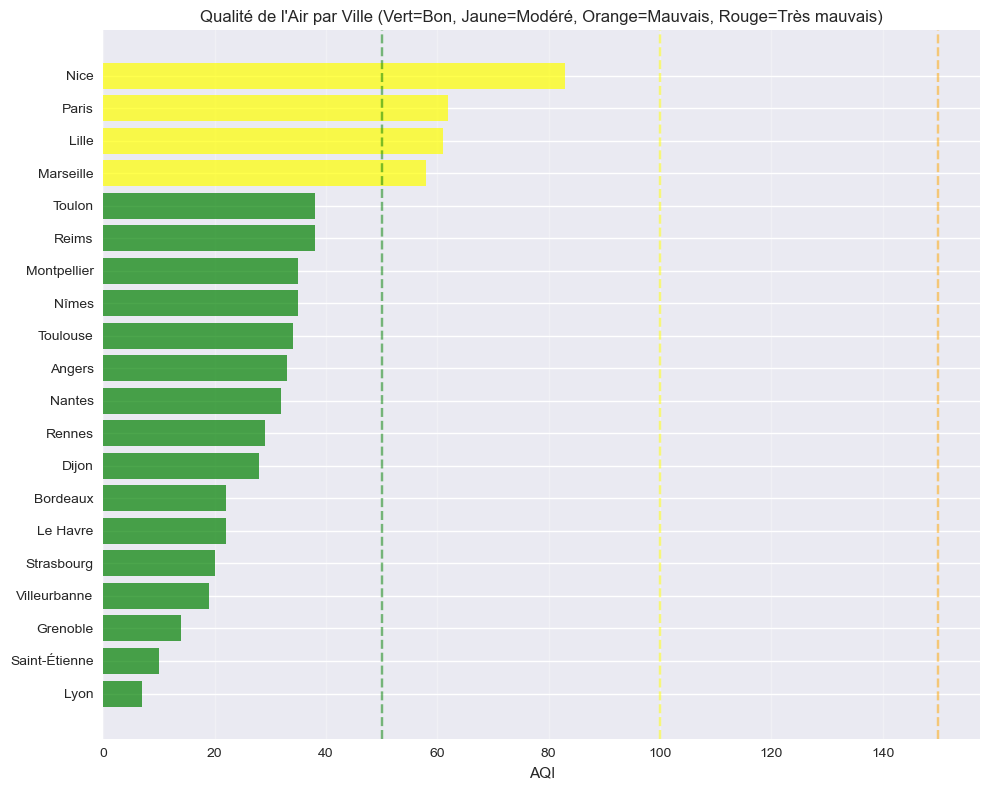

In [84]:
# Graphique AQI par ville (AQICN)
if not aqicn_df.empty and 'aqi' in aqicn_df.columns:
    plt.figure(figsize=(12, 6))
    
    # Supprimer les valeurs nulles
    aqi_data = aqicn_df.dropna(subset=['aqi'])
    
    if not aqi_data.empty:
        # Graphique en barres
        plt.subplot(1, 2, 1)
        aqi_data.plot(x='city', y='aqi', kind='bar', ax=plt.gca())
        plt.title('AQI par ville (AQICN)')
        plt.xticks(rotation=45)
        plt.ylabel('Indice de Qualité de l\'Air (AQI)')
        
        # Histogramme
        plt.subplot(1, 2, 2)
        aqi_data['aqi'].hist(bins=10, alpha=0.7)
        plt.title('Distribution des valeurs AQI')
        plt.xlabel('AQI')
        plt.ylabel('Fréquence')
        
        plt.tight_layout()
        plt.show()
# Graphique température vs AQI
if not openweather_df.empty and not aqicn_df.empty:
    # Fusion des données par ville
    merged_df = pd.merge(aqicn_df[['city', 'aqi']], 
                        openweather_df[['city', 'temperature']], 
                        on='city', how='inner')
    
    if not merged_df.empty and len(merged_df) > 1:
        plt.figure(figsize=(10, 6))
        plt.scatter(merged_df['temperature'], merged_df['aqi'], alpha=0.7, s=100)
        
        # Ajout des noms de villes
        for i, row in merged_df.iterrows():
            plt.annotate(row['city'], (row['temperature'], row['aqi']), 
                        xytext=(5, 5), textcoords='offset points', fontsize=8)
        
        plt.xlabel('Température (°C)')
        plt.ylabel('AQI')
        plt.title('Relation entre Température et Qualité de l\'Air')
        plt.grid(True, alpha=0.3)
        plt.show()
# Carte de la qualité de l'air
if not aqicn_df.empty and 'aqi' in aqicn_df.columns:
    plt.figure(figsize=(10, 8))
    
    # Créer un graphique de qualité par ville
    cities_aqi = aqicn_df.dropna(subset=['aqi']).sort_values('aqi', ascending=True)
    
    colors = ['green' if x <= 50 else 'yellow' if x <= 100 else 'orange' if x <= 150 else 'red' 
              for x in cities_aqi['aqi']]
    
    plt.barh(cities_aqi['city'], cities_aqi['aqi'], color=colors, alpha=0.7)
    plt.xlabel('AQI')
    plt.title('Qualité de l\'Air par Ville (Vert=Bon, Jaune=Modéré, Orange=Mauvais, Rouge=Très mauvais)')
    plt.grid(axis='x', alpha=0.3)
    
    # Légende des seuils AQI
    plt.axvline(x=50, color='green', linestyle='--', alpha=0.5)
    plt.axvline(x=100, color='yellow', linestyle='--', alpha=0.5)
    plt.axvline(x=150, color='orange', linestyle='--', alpha=0.5)
    
    plt.tight_layout()
    plt.show()